In [1]:
import pandas as pd
df = pd.read_excel(r'Copy of Extraction PT4 14x59 din 2016 pana in prezent - analysis S1928 (003).xlsx', sheet_name='TL4 -40 Nm' )
dataset = df.values


In [2]:
X = dataset[1:,23:30]
Y = dataset[1:,14]
X = X.astype('float')
Y = Y.astype('float')
print("X:  %s, Y: %s" % (X.shape, Y.shape))

d1 = pd.DataFrame(X)
d2 = pd.DataFrame(Y)
d1.drop([1,3,5], axis=1, inplace=True)
d1[7] = d2[0]
d1.dropna(inplace=True)
# d1.isnull().any() # Verifica daca avem vre-o valoare de tip NaN

X = d1.values[0:,:-1]
Y = d1.values[0:, -1:]
X.shape, Y.shape

X:  (918, 7), Y: (918,)


((918, 4), (918, 1))

In [3]:
from sklearn import preprocessing
min_max_scaler = preprocessing.MinMaxScaler()
X_scale = min_max_scaler.fit_transform(X)
Y_scaler = preprocessing.MinMaxScaler()
Y_scale = Y_scaler.fit_transform(Y)

X_scale.shape, Y_scale.shape

((918, 4), (918, 1))

In [4]:
from sklearn.model_selection import train_test_split
X_train, X_test, Y_train, Y_test = train_test_split(X_scale, Y_scale, test_size=0.2)
X_train.shape, Y_train.shape, X_test.shape, Y_test.shape


((734, 4), (734, 1), (184, 4), (184, 1))

In [5]:
import keras
from keras import metrics
from keras import regularizers
from keras.models import Sequential
from keras.layers import Dense, Dropout, Flatten, Activation
from keras.layers import Conv2D, MaxPooling2D
from keras.optimizers import Adam, RMSprop
from keras.callbacks import TensorBoard, EarlyStopping, ModelCheckpoint
from keras.utils import plot_model
from keras.models import load_model


def basic_model_3(x_size, y_size):
    t_model = Sequential()
    t_model.add(Dense(80, activation="tanh", kernel_initializer='normal', input_shape=(x_size,)))
    t_model.add(Dropout(0.2))
    t_model.add(Dense(120, activation="relu", kernel_initializer='normal', 
        kernel_regularizer=regularizers.l1(0.01), bias_regularizer=regularizers.l1(0.01)))
    t_model.add(Dropout(0.1))
    t_model.add(Dense(20, activation="relu", kernel_initializer='normal', 
        kernel_regularizer=regularizers.l1_l2(0.01), bias_regularizer=regularizers.l1_l2(0.01)))
    t_model.add(Dropout(0.1))
    t_model.add(Dense(10, activation="relu", kernel_initializer='normal'))
    t_model.add(Dropout(0.0))
    t_model.add(Dense(y_size))
    t_model.compile(
        loss='mean_squared_error',
        optimizer='nadam',
        metrics=[metrics.mae])
    return(t_model)

model = basic_model_3(4, 1)
model.summary()

Using TensorFlow backend.
W0917 10:09:28.372403  9172 deprecation_wrapper.py:119] From C:\Users\Alecs\Anaconda3\envs\CChirita\lib\site-packages\keras\backend\tensorflow_backend.py:74: The name tf.get_default_graph is deprecated. Please use tf.compat.v1.get_default_graph instead.

W0917 10:09:28.406415  9172 deprecation_wrapper.py:119] From C:\Users\Alecs\Anaconda3\envs\CChirita\lib\site-packages\keras\backend\tensorflow_backend.py:517: The name tf.placeholder is deprecated. Please use tf.compat.v1.placeholder instead.

W0917 10:09:28.409407  9172 deprecation_wrapper.py:119] From C:\Users\Alecs\Anaconda3\envs\CChirita\lib\site-packages\keras\backend\tensorflow_backend.py:4115: The name tf.random_normal is deprecated. Please use tf.random.normal instead.

W0917 10:09:28.428410  9172 deprecation_wrapper.py:119] From C:\Users\Alecs\Anaconda3\envs\CChirita\lib\site-packages\keras\backend\tensorflow_backend.py:133: The name tf.placeholder_with_default is deprecated. Please use tf.compat.v1.p

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense_1 (Dense)              (None, 80)                400       
_________________________________________________________________
dropout_1 (Dropout)          (None, 80)                0         
_________________________________________________________________
dense_2 (Dense)              (None, 120)               9720      
_________________________________________________________________
dropout_2 (Dropout)          (None, 120)               0         
_________________________________________________________________
dense_3 (Dense)              (None, 20)                2420      
_________________________________________________________________
dropout_3 (Dropout)          (None, 20)                0         
_________________________________________________________________
dense_4 (Dense)              (None, 10)                210       
__________

In [6]:
epochs = 500
batch_size = 128

print('Epochs: ', epochs)
print('Batch size: ', batch_size)




keras_callbacks = [
    # ModelCheckpoint('/tmp/keras_checkpoints/model.{epoch:02d}-{val_loss:.2f}.hdf5', monitor='val_loss', save_best_only=True, verbose=2)
    # ModelCheckpoint('/tmp/keras_checkpoints/model.{epoch:02d}.hdf5', monitor='val_loss', save_best_only=True, verbose=0)
    # TensorBoard(log_dir='/tmp/keras_logs/model_3', histogram_freq=0, write_graph=True, write_images=True, embeddings_freq=0, embeddings_layer_names=None, embeddings_metadata=None),
    EarlyStopping(monitor='val_mean_absolute_error', patience=20, verbose=0)
]



history = model.fit(X_train, Y_train,
    batch_size=batch_size,
    epochs=epochs,
    shuffle=True,
    verbose=0, # Change it to 2, if wished to observe execution
    validation_data=(X_test, Y_test),
    callbacks=keras_callbacks)
 

Epochs:  500
Batch size:  128


In [8]:
train_score = model.evaluate(X_train, Y_train, verbose=0)
valid_score = model.evaluate(X_test, Y_test, verbose=0)

print('Train MAE: ', round(train_score[1], 4), ', Train Loss: ', round(train_score[0], 4)) 
print('Val MAE: ', round(valid_score[1], 4), ', Val Loss: ', round(valid_score[0], 4))

Train MAE:  0.166 , Train Loss:  0.1073
Val MAE:  0.153 , Val Loss:  0.101


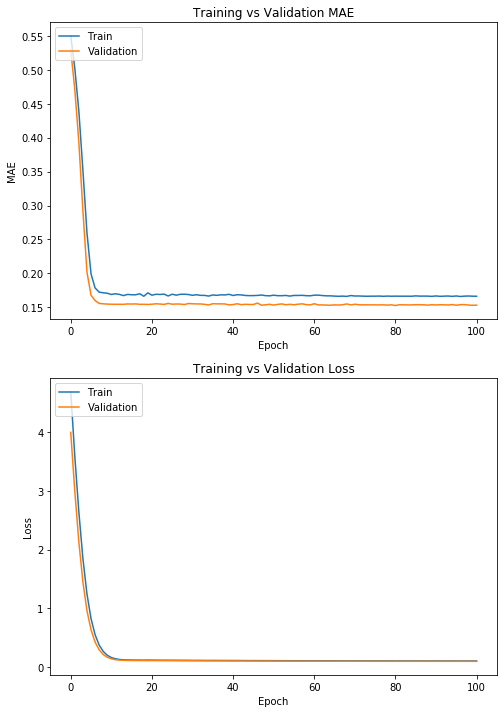

In [12]:
import matplotlib.pyplot as plt
def plot_hist(h, xsize=6, ysize=10):
    # Prepare plotting
    fig_size = plt.rcParams["figure.figsize"]
    plt.rcParams["figure.figsize"] = [xsize, ysize]
    fig, axes = plt.subplots(nrows=4, ncols=4, sharex=True)
    
    # summarize history for MAE
    plt.subplot(211)
    plt.plot(h['mean_absolute_error'])
    plt.plot(h['val_mean_absolute_error'])
    plt.title('Training vs Validation MAE')
    plt.ylabel('MAE')
    plt.xlabel('Epoch')
    plt.legend(['Train', 'Validation'], loc='upper left')
    
    # summarize history for loss
    plt.subplot(212)
    plt.plot(h['loss'])
    plt.plot(h['val_loss'])
    plt.title('Training vs Validation Loss')
    plt.ylabel('Loss')
    plt.xlabel('Epoch')
    plt.legend(['Train', 'Validation'], loc='upper left')
    
    # Plot it all in IPython (non-interactive)
    plt.draw()
    plt.show()

    return

plot_hist(history.history, xsize=8, ysize=12)

In [13]:
for i in range(10):
    p = model.predict(X_train[i].reshape(1, 4))
    print(p, Y_train[i], p/float(Y_train[i]))

[[0.5723151]] [0.68473684] [[0.8358176]]
[[0.57231694]] [0.59157895] [[0.96743965]]
[[0.5723158]] [0.48105263] [[1.1897156]]
[[0.5723145]] [0.63157895] [[0.90616465]]
[[0.57231665]] [0.57526316] [[0.994878]]
[[0.5723177]] [0.46526316] [[1.2300947]]
[[0.572314]] [0.59052632] [[0.9691592]]
[[0.57231593]] [0.59736842] [[0.95806193]]
[[0.5723132]] [0.78947368] [[0.72493]]
[[0.5723165]] [0.42105263] [[1.3592517]]
